#  Standard Frequentist Discovery
StandardFrequentistDiscovery

 This is a standard demo that can be used with any ROOT file
 prepared in the standard way.  You specify:
 - name for input ROOT file
 - name of workspace inside ROOT file that holds model and data
 - name of ModelConfig that specifies details for calculator tools
 - name of dataset

 With default parameters the macro will attempt to run the
 standard hist2workspace example and read the ROOT file
 that it produces.




**Author:**  Sven Kreiss, Kyle Cranmer  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:27 AM.</small></i>

In [1]:
%%cpp -d
#include "TFile.h"
#include "TROOT.h"
#include "TH1F.h"
#include "TF1.h"
#include "TCanvas.h"
#include "TStopwatch.h"

#include "RooWorkspace.h"
#include "RooAbsData.h"
#include "RooRandom.h"
#include "RooRealSumPdf.h"
#include "RooNumIntConfig.h"

#include "RooStats/ModelConfig.h"
#include "RooStats/ToyMCImportanceSampler.h"
#include "RooStats/HypoTestResult.h"
#include "RooStats/HypoTestPlot.h"
#include "RooStats/SamplingDistribution.h"
#include "RooStats/ProfileLikelihoodTestStat.h"
#include "RooStats/SimpleLikelihoodRatioTestStat.h"
#include "RooStats/ProfileLikelihoodCalculator.h"
#include "RooStats/LikelihoodInterval.h"
#include "RooStats/LikelihoodIntervalPlot.h"

#include "RooStats/FrequentistCalculator.h"
#include "TSystem.h"

#include <vector>

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace RooFit;
using namespace RooStats;

 Arguments are defined. 

In [3]:
const char *infile = "";
const char *workspaceName = "channel1";
const char *modelConfigNameSB = "ModelConfig";
const char *dataName = "obsData";
int toys = 1000;
double poiValueForBackground = 0.0;
double poiValueForSignal = 1.0;

The workspace contains the model for s+b. the b model is "autogenerated"
 by copying s+b and setting the one parameter of interest to zero.
 To keep the script simple, multiple parameters of interest or different
 functional forms of the b model are not supported.

For now, assume there is only one parameter of interest, and these are
 its values:

-------------------------------------------------------
 First part is just to access a user-defined file
 or create the standard example file if it doesn't exist

In [4]:
const char *filename = "";
if (!strcmp(infile, "")) {
   filename = "results/example_channel1_GammaExample_model.root";
   bool fileExist = !gSystem->AccessPathName(filename); // note opposite return code
   // if file does not exists generate with histfactory
   if (!fileExist) {
#ifdef _WIN32
      cout << "HistFactory file cannot be generated on Windows - exit" << endl;
      return -1;
#endif
      // Normally this would be run on the command line
      cout << "will run standard hist2workspace example" << endl;
      gROOT->ProcessLine(".! prepareHistFactory .");
      gROOT->ProcessLine(".! hist2workspace config/example.xml");
      cout << "\n\n---------------------" << endl;
      cout << "Done creating example input" << endl;
      cout << "---------------------\n\n" << endl;
   }

} else
   filename = infile;

Try to open the file

In [5]:
TFile *file = TFile::Open(filename);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



If input file was specified byt not found, quit

In [6]:
if (!file) {
   cout << "StandardRooStatsDemoMacro: Input file " << filename << " is not found" << endl;
   return -1;
}

-------------------------------------------------------
 Tutorial starts here
 -------------------------------------------------------

In [7]:
TStopwatch *mn_t = new TStopwatch;
mn_t->Start();

Get the workspace out of the file

In [8]:
RooWorkspace *w = (RooWorkspace *)file->Get(workspaceName);
if (!w) {
   cout << "workspace not found" << endl;
   return -1.0;
}

Get the modelconfig out of the file

In [9]:
ModelConfig *mc = (ModelConfig *)w->obj(modelConfigNameSB);

Get the data out of the file

In [10]:
RooAbsData *data = w->data(dataName);

Make sure ingredients are found

In [11]:
if (!data || !mc) {
   w->Print();
   cout << "data or ModelConfig was not found" << endl;
   return -1.0;
}

RooRealVar *firstPOI = (RooRealVar *)mc->GetParametersOfInterest()->first();
firstPOI->setVal(poiValueForSignal);
mc->SetSnapshot(*mc->GetParametersOfInterest());

Create null model

In [12]:
ModelConfig *mcNull = mc->Clone("ModelConfigNull");
firstPOI->setVal(poiValueForBackground);
mcNull->SetSnapshot(*(RooArgSet *)mcNull->GetParametersOfInterest()->snapshot());

----------------------------------------------------
 Configure a ProfileLikelihoodTestStat and a SimpleLikelihoodRatioTestStat
 to use simultaneously with ToyMCSampler

In [13]:
ProfileLikelihoodTestStat *plts = new ProfileLikelihoodTestStat(*mc->GetPdf());
plts->SetOneSidedDiscovery(true);
plts->SetVarName("q_{0}/2");

----------------------------------------------------
 configure the ToyMCImportanceSampler with two test statistics

In [14]:
ToyMCSampler toymcs(*plts, 50);

Since this tool needs to throw toy mc the pdf needs to be
 extended or the tool needs to know how many entries in a dataset
 per pseudo experiment.
 In the 'number counting form' where the entries in the dataset
 are counts, and not values of discriminating variables, the
 datasets typically only have one entry and the PDF is not
 extended.

In [15]:
if (!mc->GetPdf()->canBeExtended()) {
   if (data->numEntries() == 1) {
      toymcs.SetNEventsPerToy(1);
   } else
      cout << "Not sure what to do about this model" << endl;
}

We can use proof to speed things along in parallel
 ProofConfig pc(*w, 2, "user@yourfavoriteproofcluster", false);

In [16]:
ProofConfig pc(*w, 2, "", false);

Toymcs.setproofconfig(&pc);    // enable proof

Instantiate the calculator

In [17]:
FrequentistCalculator freqCalc(*data, *mc, *mcNull, &toymcs);
freqCalc.SetToys(toys, toys); // null toys, alt toys

Run the calculator and print result

In [18]:
HypoTestResult *freqCalcResult = freqCalc.GetHypoTest();
freqCalcResult->GetNullDistribution()->SetTitle("b only");
freqCalcResult->GetAltDistribution()->SetTitle("s+b");
freqCalcResult->Print();
double pvalue = freqCalcResult->NullPValue();


=== Using the following for ModelConfigNull ===
Observables:             RooArgSet:: = (obs_x_channel1)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst3,beta_syst2,gamma_stat_channel1_bin_0,gamma_stat_channel1_bin_1)
Global Observables:      RooArgSet:: = (nom_beta_syst2,nom_alpha_syst3,nom_gamma_stat_channel1_bin_0,nom_gamma_stat_channel1_bin_1)
PDF:                     RooProdPdf::model_channel1[ lumiConstraint * alpha_syst1Constraint * beta_syst2Constraint * alpha_syst3Constraint * gamma_stat_channel1_bin_0_constraint * gamma_stat_channel1_bin_1_constraint * channel1_model(obs_x_channel1) ] = 0.208662
Snapshot:                
  1) 0x7fb7454cb980 RooRealVar:: SigXsecOverSM = 0  L(0 - 3)  "SigXsecOverSM"


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (obs_x_channel1)
Parameters of Interest:  RooArgSet:: = (SigXsecOverSM)
Nuisance Parameters:     RooArgSet:: = (alpha_syst3,beta_syst2,gamma

Stop timing

In [19]:
mn_t->Stop();
cout << "total CPU time: " << mn_t->CpuTime() << endl;
cout << "total real time: " << mn_t->RealTime() << endl;

total CPU time: 12.91
total real time: 14.1633


Plot

In [20]:
TCanvas *c1 = new TCanvas();
HypoTestPlot *plot = new HypoTestPlot(*freqCalcResult, 100, -0.49, 9.51);
plot->SetLogYaxis(true);

Add chi2 to plot

In [21]:
int nPOI = 1;
TF1 *f = new TF1("f", TString::Format("1*ROOT::Math::chisquared_pdf(2*x,%d,0)", nPOI), 0, 20);
f->SetLineColor(kBlack);
f->SetLineStyle(7);
plot->AddTF1(f, TString::Format("#chi^{2}(2x,%d)", nPOI));

plot->Draw();
c1->SaveAs("standard_discovery_output.pdf");

return pvalue;

Info in <TCanvas::Print>: pdf file standard_discovery_output.pdf has been created


Draw all canvases 

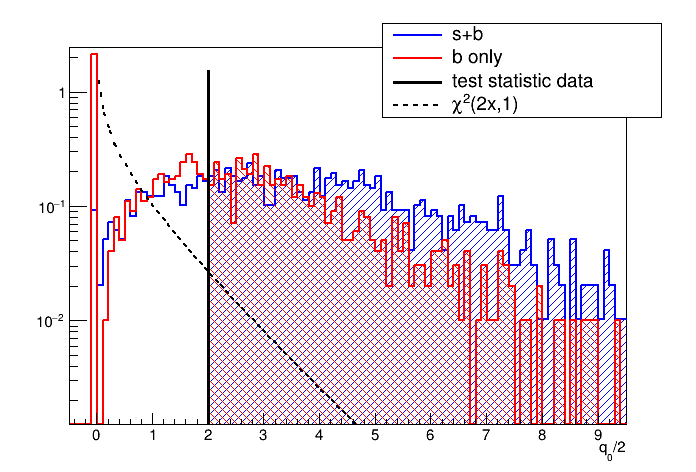

In [22]:
gROOT->GetListOfCanvases()->Draw()